In [ ]:
# Install required libraries
!pip install ta tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=8865c4ead813fddbc046a8d20cf8c23ff85425fedc5bf8e2b20093e11f5ca1f7
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
# --- 1) Determinism & seeds
import os, random, numpy as np
SEED = 42

# Python & NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow determinism flags
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

import tensorflow as tf
tf.keras.utils.set_random_seed(SEED)            # sets python, numpy, and tf seeds

# Reduce nondeterminism from thread scheduling
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# For newer TF versions
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass


### Imports

In [ ]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf

# Technical Analysis
from ta import add_all_ta_features

# Statistics
from statsmodels.tsa.stattools import adfuller

# Machine Learning and Deep Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reporting
import matplotlib.pyplot as plt


### Data Extraction

In [ ]:
# Data Extraction
start_date = "2017-12-01"
end_date = "2025-10-01"
symbol = "BTC-USD"     # change it as needed "ETH-USD", "XRP-USD"
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
print(df.shape)
df.head()

[*********************100%***********************]  1 of 1 completed

(2861, 5)


,Close,High,Low,Open,Volume
Date,,,,,
2017-12-01,10975.599609,11046.700195,9694.650391,10198.599609,6783119872
2017-12-02,11074.599609,11320.200195,10905.099609,10978.299805,5138500096
2017-12-03,11323.200195,11858.700195,10862.000000,11082.700195,6608309760
2017-12-04,11657.200195,11657.200195,11081.799805,11315.400391,6132409856
2017-12-05,11916.700195,12032.000000,11604.599609,11685.700195,6895260160


In [ ]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df.head()

,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,10975.599609,11046.700195,9694.650391,10198.599609,6783119872,6.069709e+09,6783119872,0.894825,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10975.599609,0.000000,0.000000,0.000000
2017-12-02,11074.599609,11320.200195,10905.099609,10978.299805,5138500096,5.127665e+09,11921619968,0.430115,5.087115e+11,5993.852084,...,0.071906,0.014381,0.057525,-1.969508,-0.393902,-1.575606,11018.447437,0.902001,0.897957,0.902001
2017-12-03,11323.200195,11858.700195,10862.000000,11082.700195,6608309760,4.635043e+09,18529929728,0.250138,6.707284e+11,3735.945227,...,0.307284,0.072962,0.234322,-1.730980,-0.661317,-1.069663,11147.496158,2.244782,2.219957,3.167030
2017-12-04,11657.200195,11657.200195,11081.799805,11315.400391,6132409856,1.076745e+10,24662339584,0.436595,8.675136e+11,85.852993,...,0.727186,0.203807,0.523379,-2.106013,-0.950256,-1.155756,11365.861032,2.949696,2.907030,6.210144
2017-12-05,11916.700195,12032.000000,11604.599609,11685.700195,6895260160,1.394244e+10,31557599744,0.441809,9.992002e+11,2781.870551,...,1.229076,0.408861,0.820215,-1.443943,-1.048994,-0.394950,11582.265655,2.226092,2.201676,8.574480


In [ ]:
# ---- Target Setting ----
df["TARGET"] = 0
df.loc[df["Close"].shift(-1) > df["Close"], "TARGET"] = 1

,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,10975.599609,11046.700195,9694.650391,10198.599609,6783119872,6.069709e+09,6783119872,0.894825,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10975.599609,0.000000,0.000000,0.000000,1
2017-12-02,11074.599609,11320.200195,10905.099609,10978.299805,5138500096,5.127665e+09,11921619968,0.430115,5.087115e+11,5993.852084,...,0.014381,0.057525,-1.969508,-0.393902,-1.575606,11018.447437,0.902001,0.897957,0.902001,1
2017-12-03,11323.200195,11858.700195,10862.000000,11082.700195,6608309760,4.635043e+09,18529929728,0.250138,6.707284e+11,3735.945227,...,0.072962,0.234322,-1.730980,-0.661317,-1.069663,11147.496158,2.244782,2.219957,3.167030,1
2017-12-04,11657.200195,11657.200195,11081.799805,11315.400391,6132409856,1.076745e+10,24662339584,0.436595,8.675136e+11,85.852993,...,0.203807,0.523379,-2.106013,-0.950256,-1.155756,11365.861032,2.949696,2.907030,6.210144,1
2017-12-05,11916.700195,12032.000000,11604.599609,11685.700195,6895260160,1.394244e+10,31557599744,0.441809,9.992002e+11,2781.870551,...,0.408861,0.820215,-1.443943,-1.048994,-0.394950,11582.265655,2.226092,2.201676,8.574480,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-26,109712.828125,110359.195312,108728.976562,109041.296875,57738288949,6.292923e+12,1904442805893,0.021497,-4.269466e+13,-4469.981792,...,0.118243,-0.583645,0.077958,-5.975602,6.053560,113471.030906,0.608476,0.606633,899.606691,0
2025-09-27,109681.945312,109778.500000,109144.296875,109707.140625,26308042910,6.311221e+12,1878134762983,0.030925,-3.671149e+13,-199.333227,...,-0.036951,-0.620776,-3.976500,-5.575781,1.599282,112861.800348,-0.028149,-0.028153,899.325314,1
2025-09-28,112122.640625,112375.484375,109236.945312,109681.945312,33371048505,6.339215e+12,1911505811488,0.048990,-1.983148e+13,12647.965863,...,-0.155230,-0.473116,-6.122227,-5.685071,-0.437157,112803.238179,2.225248,2.200851,921.562781,1


### Data Preprocessing - Stationarity

In [ ]:
# Identify non-stationary columns among FEATURES ONLY
non_stationaries = []
for col in df.columns:
    if col == "TARGET":
        continue  # don't test/transform the label
    try:
        dftest = adfuller(df[col].values)
        p_value = dftest[1]
        t_test = dftest[0] < dftest[4]["1%"]
        if p_value > 0.05 or not t_test:
            non_stationaries.append(col)
    except Exception:
        # skip non-numeric or problematic columns, if any
        pass

In [ ]:
print(f"Non-Stationary Features Found: {len(non_stationaries)}")
print(non_stationaries)

Non-Stationary Features Found: 33
['Close', 'High', 'Low', 'Open', 'Volume', 'volume_adi', 'volume_obv', 'volume_vpt', 'volume_vwap', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_atr', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_ichimoku_conv', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_psar_up', 'trend_psar_down', 'momentum_kama', 'others_cr']


In [ ]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [ ]:
df_stationary.shape

(2860, 92)

In [ ]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.shape

(2860, 91)

### Scaling and Splitting

---



In [ ]:
# Split Target from Feature set
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [ ]:
# ==== Feature Scaling (AVOID LEAKAGE) ====
train_limit = int(0.8 * len(df_stationary))  # time-aware split
scaler = StandardScaler().fit(X.iloc[:train_limit].values)  # fit on TRAIN only
X_fs_train = scaler.transform(X.iloc[:train_limit].values)
X_fs_test  = scaler.transform(X.iloc[train_limit:].values)

In [ ]:
X_train = X_fs_train
X_test  = X_fs_test
y_train = y[:train_limit]
y_test  = y[train_limit:]

### PCA

In [ ]:
# PCA
n_components = 25
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [ ]:
# Calculate the variance explained by Principle Components
print("Variance of each component: ", pca.explained_variance_ratio_)
print("\n Total Variance Explained: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))


Variance of each component:  [0.37611365 0.09721205 0.0624407  0.0435115  0.03855066 0.03087177
 0.02488588 0.02204679 0.02089959 0.01957023 0.01950735 0.0162459
 0.01292883 0.0123502  0.01208668 0.01132711 0.01115477 0.01030566
 0.00998301 0.00948484 0.00829539 0.00796404 0.00761427 0.00707644
 0.00644886]

 Total Variance Explained:  89.89


In [ ]:
# Reshape PCA output to 3D (samples, timesteps, features)
# Each sample is treated as a single timestep with n_components features
X_train_3d = np.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_test_3d = np.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))

### LSTM

In [ ]:
# Build LSTM model
model = Sequential()
model.add(GRU(64, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit model
history = model.fit(
    X_train_3d, y_train,
    validation_split=0.2,
    epochs=50,
    shuffle=False,
    batch_size=32,
    verbose=1
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4996 - loss: 0.7227 - val_accuracy: 0.4934 - val_loss: 0.7014
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5226 - loss: 0.7040 - val_accuracy: 0.4847 - val_loss: 0.6983
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5120 - loss: 0.7020 - val_accuracy: 0.4716 - val_loss: 0.6968
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5275 - loss: 0.6913 - val_accuracy: 0.4803 - val_loss: 0.6956
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5113 - loss: 0.6969 - val_accuracy: 0.4869 - val_loss: 0.6951
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5273 - loss: 0.6935 - val_accuracy: 0.5066 - val_loss: 0.6945
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5141 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5233 - loss: 0.6969 - val_accuracy: 0.4956 - val_loss

In [ ]:
# Predictions
y_pred_prob = model.predict(X_test_3d)
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Test Accuracy (GRU): {accuracy:.3f}")
print(f"Test Precision (GRU): {precision:.3f}")
print(f"Test Recall (GRU): {recall:.3f}")
print(f"Test F1 Score (GRU): {f1:.3f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy (GRU): 0.524
Test Precision (GRU): 0.527
Test Recall (GRU): 0.538
Test F1 Score (GRU): 0.533


### Trading Strategy

In [ ]:
# Add Predictions to Test Data
df_preprocess = df.iloc[1:]
df_test = df_preprocess.iloc[train_limit:].copy()

In [ ]:
# If the classification is 1 then buy, else if 0 then do nothing - long only strategy
df_test["GRU_Signal"] = y_pred
df_test["Main_Signal"] = df_test["GRU_Signal"].shift(1)

In [ ]:
# Calculate Benchmark Returns
df_test["lrets_bench"] = np.log(df_test["Close"] / df_test["Close"].shift(1))
df_test["bench_prod"] = df_test["lrets_bench"].cumsum()
df_test["bench_prod_exp"] = np.exp(df_test["bench_prod"]) - 1


In [ ]:
# Calculate Strategy Returns
df_test["lrets"] = np.log(df_test["Open"].shift(-1) / df_test["Open"])
df_test["lrets_strat"] = df_test["lrets"] * df_test["Main_Signal"]
df_test["lrets_prod"] = df_test["lrets_strat"].cumsum()
df_test["strat_prod_exp"] = np.exp(df_test["lrets_prod"]) - 1

In [ ]:
# Drop NA values
df_test.dropna(inplace=True)

### Metrics

In [ ]:
# Sharpe Ratio
def sharpe_ratio(returns_series):
    N = 365
    NSQRT = np.sqrt(N)
    rf = 0  # Assuming risk-free rate = 0
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    return round((mean - rf) / sigma, 2)

# Max Drawdown
def max_drawdown(returns):
    equity = np.exp(np.cumsum(returns))
    running_max = np.maximum.accumulate(equity)
    drawdown = (equity / running_max) - 1.0
    return drawdown.min()


def win_ratio(returns, signals):
    returns = pd.Series(returns)
    signals = pd.Series(signals).reindex(returns.index).fillna(0)

    # Filter only trade days
    trade_returns = returns[signals == 1]

    if len(trade_returns) == 0:
        return np.nan  # no trades executed

    wins = (trade_returns > 0).sum()
    return round(wins / len(trade_returns), 3)


In [ ]:
# Calculate Metrics
bench_rets = round(df_test["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_test["strat_prod_exp"].values[-1] * 100, 1)
bench_sharpe = sharpe_ratio(df_test["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_test["lrets_strat"].values)

# Max Drawdown and Win Ratio
bench_drawdown = max_drawdown(df_test["lrets_bench"].values)
strat_drawdown = max_drawdown(df_test["lrets_strat"].values)
bench_win_ratio = win_ratio(df_test["lrets_bench"], np.ones_like(df_test["lrets_bench"]))
strat_win_ratio = win_ratio(df_test["lrets_strat"], df_test["Main_Signal"])

print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")
print("---- ---- ---- ---- ---- ----")
print(f"Max Drawdown Benchmark: {bench_drawdown}")
print(f"Max Drawdown Strategy: {strat_drawdown}")
print("---- ---- ---- ---- ---- ----")
print(f"Win Ratio Benchmark: {bench_win_ratio}")
print(f"Win Ratio Strategy: {strat_win_ratio}")


Returns Benchmark: 67.5%
Returns Strategy: 96.5%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.69
Sharpe Strategy: 1.2
---- ---- ---- ---- ---- ----
Max Drawdown Benchmark: -0.28144478116207905
Max Drawdown Strategy: -0.2137381938627848
---- ---- ---- ---- ---- ----
Win Ratio Benchmark: nan
Win Ratio Strategy: 0.532


### Visualization

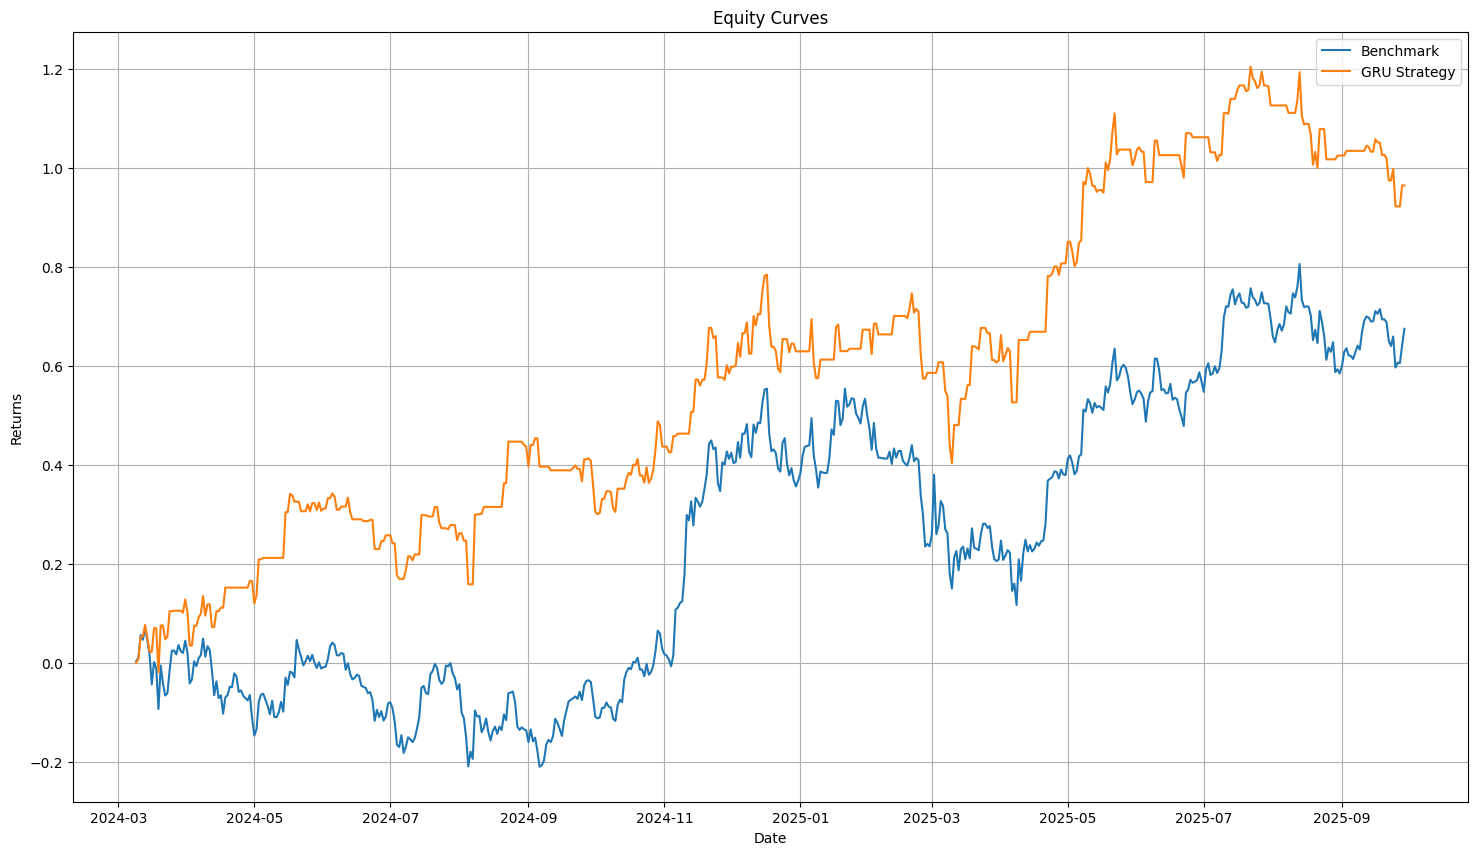

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(df_test["bench_prod_exp"], label="Benchmark")
plt.plot(df_test["strat_prod_exp"], label="GRU Strategy")
plt.legend()
plt.title("Equity Curves")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.grid(True)
plt.show()